## Table of Contents
0. Notebook Setup
1. RFM Modeling
2. Exporting Dataframes

--------------
### 0. Importing Packages/Data

In [86]:
# 0.0 - Importing Packages
import pandas as pd
import numpy as np
import os
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pathlib import Path

In [87]:
# 0.2 - Assign storedf to Superstore Excel file
# The warning is fine!
storedf = pd.read_excel(Path('Datasets') / 'Sample - Superstore.xls')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [88]:
# 0.3 - Checking the shape and contents of our dataframe
print(storedf.shape)
display(storedf.head())

(9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [89]:
# 0.4 - Checking NaNs. Only 11 in Postal Code (which is acceptable)
storedf.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
Quantity          0
Discount          0
Profit            0
dtype: int64

In [90]:
# 0.5 - Order Date is already a datetime - we don't need to convert it
storedf['Order Date']

0      2017-11-08
1      2017-11-08
2      2017-06-12
3      2016-10-11
4      2016-10-11
          ...    
9989   2015-01-21
9990   2018-02-26
9991   2018-02-26
9992   2018-02-26
9993   2018-05-04
Name: Order Date, Length: 9994, dtype: datetime64[ns]

-------------
### 1. RFM Modeling

In [91]:
# 1.0 - For our recency calculations, we're using our most recent purchase date as the "baseline" date
latest_date = storedf['Order Date'].max()
print(latest_date)

2018-12-30 00:00:00


In [92]:
# 1.1 - Create RFM scores by aggregating Customer ID and using 3 separate lambda functions to form a new dataframe (RFMdf)
# R is established with the difference between the current date (latest_date) and the customer ID's most recent date of purchase
# F is the number of purchases each customer ID has made, or the count of records each customer ID has in the database
# M is the sum of sales contributed by each customer ID
RFMdf = storedf.groupby('Customer ID').agg(
    Recency = ('Order Date', lambda x: (latest_date - x.max()).days), 
    Frequency = ('Order ID', 'count'), 
    Monetary = ('Sales', 'sum') 
)

In [93]:
# 1.2 - Check the shape and preview the contents of RFMscores
print(RFMdf.shape)
display(RFMdf.head())

(793, 3)


,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,184,11,5563.560
AA-10375,19,15,1056.390
AA-10480,259,12,1790.512
AA-10645,55,18,5086.935
AB-10015,415,6,886.156


count     793.000000
mean      146.773014
std       186.111367
min         0.000000
25%        30.000000
50%        75.000000
75%       183.000000
max      1165.000000
Name: Recency, dtype: float64

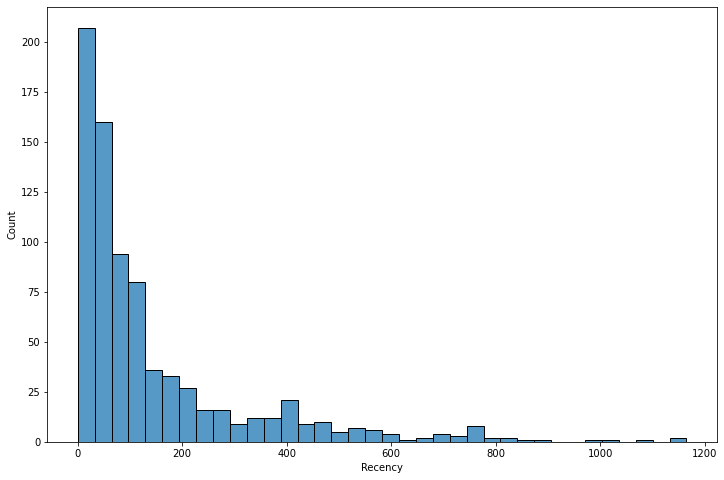

In [94]:
# 1.3- Should we consider our recency mean to be "higher than desirable?"
# A historical comparison would give us clearer insight into that question
# This would mean that customer retention isn't our strongsuit (high churn)
# We'll save the rest of our analysis for later on in Tableau
plt.figure(figsize=(12,8))
r = RFMdf['Recency']
ax = sns.histplot(r)
RFMdf.Recency.describe()

In [95]:
# 1.4 - Creating scored R/F/M columns by passing respective columns to .pdcut, which divides values into quantiles within a range
# Recency is interpreted inversely compared to Frequency and Monetary
# Low Recency translates to high R values, whereas Low Frequency/Monetary transalte to low F/M values
# Our most loyal/engaged/profitable customers will have a score of 444, and the least will be closer to 111
# We include .astype to convert the category data type to an int
RFMdf['R'] = pd.qcut(RFMdf["Recency"], 4, labels = range(4,0,-1)).astype(int)
RFMdf['F'] = pd.qcut(RFMdf["Frequency"], 4, labels = range(1,5)).astype(int)
RFMdf['M'] = pd.qcut(RFMdf["Monetary"], 4, labels = range(1,5)).astype(int)

In [96]:
# 1.5 - A quick preview of our functions' results
RFMdf.head(10)

,Recency,Frequency,Monetary,R,F,M
Customer ID,,,,,,
AA-10315,184,11,5563.560,1,2,4
AA-10375,19,15,1056.390,4,3,1
AA-10480,259,12,1790.512,1,2,2
AA-10645,55,18,5086.935,3,4,4
AB-10015,415,6,886.156,1,1,1
AB-10060,54,18,7755.620,3,4,4
AB-10105,41,20,14473.571,3,4,4
AB-10150,41,12,966.710,3,2,1
AB-10165,25,14,1113.838,4,3,1


In [97]:
# 1.6 - Concatenating RFM values for a new column: RFMgroup
RFMdf['RFMgroup'] = RFMdf.R.map(str) + RFMdf.F.map(str) + RFMdf.M.map(str)
RFMdf.head()
RFMdf.reset_index(inplace=True)

In the next cell, we write a function that categorizes customer loyalty groups by assessing RFM score combinations
| Group | Requirement | Score e.g. | Description |
| :--------- | :--------- | :--------- | :--------- |
| Platinum | All scores = 4 | 444 | Highest-scoring, most loyal customers |
| Gold | All scores >= 3 | 333, 344 | At least 3 in all categories; captures customers who are second-most loyal |
| Silver | Moderate/high scores | 133, 324 | Casts a wide net to capture customers who aren't quite gold, but are very loyal |
| Churn Risk | Moderate M/F; Low R | 122, 133 | No recent purchases; at risk of defecting to competitors |
| High-Spend | High M; Low R/F | 113, 214 | Top 25% of sales; Large purchases but very infrequent |
| New | High R; Low M | 411, 431 | Made their first purchase recently, or their first purchase in a long time |
| Churning | Lowest scores | 111, 112 | Lowest loyalty group; likely receptive to competitor-focused targeting | 

We then apply our function to RFMdf, and create a new **Loyalty** Column

In [98]:
# 1.7 - Establishing loyalty groups and creating a new column in RFMdf
Loyalty = []
def loyalty_groups(r):
        if (r['R'] == 4 and r['F'] == 4 and r['M'] == 4):
            return 'Platinum' # Has all 4s
        elif (r['R'] >=3 and r['F'] >= 3 and r['M'] >= 3): 
            return 'Gold' # Has at least 3 in each category
        elif (r['R'] >= 2 and r['F'] >= 2 and r['M'] >= 2) or \
             (r['R'] >= 1 and r['F'] == 4 and r['M'] >= 1):
            return 'Silver' # Loyal customers have moderate F/M scores, represent a dependable majority
        elif (r['R'] >= 1 and r['F'] >= 2 and r['M'] == 2) or \
             (r['R'] >= 1 and r['F'] >= 2 and r['M'] == 3):
            return 'Churn Risk' # Moderate M with low R/F
        elif (r['R'] <= 2 and r['F'] >= 1 and r['M'] >= 3):
            return 'High-Spend' # High M and Low R/F, likely purchased with a discount/promotion
        elif (r['R'] >= 3 and r['F'] >= 1 and r['M'] >= 1):
            return 'New' # High R, new customers
        else: 
            return 'Churning' # Customers with the lowest R/F values
RFMdf['Loyalty'] = RFMdf.apply(loyalty_groups, axis = 1)

In [99]:
# 1.8 - Checkpoint: here's the count of customer ID by loyalty
RFMdf.Loyalty.value_counts()

Silver        262
Churning      160
Gold          149
New           107
Churn Risk     53
High-Spend     33
Platinum       29
Name: Loyalty, dtype: int64

--------------
### 2. Exporting Dataframes

In [100]:
# 2.0 - Merging storedf and RFMdf
storedf = storedf.merge(RFMdf, on= 'Customer ID')

In [101]:
# 2.1 - Once we're in Tableau, we'll be averaging certain measures like Profit and Discount
# This cell is just for checking some of our future Tableau calculations for correctness
storedf[['Sales', 'Quantity', 'Discount', 'Profit', 'Recency', 'Frequency', 'Monetary']].agg(['sum', 'mean']).astype(int)

,Sales,Quantity,Discount,Profit,Recency,Frequency,Monetary
sum,2297200,37873,1561,286397,1201910,156816,35915382
mean,229,3,0,28,120,15,3593


In [102]:
# 2.2 - One last checkpoint before we export and head into Tableau
print(storedf.shape)
display(storedf.head(5))

(9994, 29)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Discount,Profit,Recency,Frequency,Monetary,R,F,M,RFMgroup,Loyalty
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,0.0,41.9136,338,5,1148.78,1,1,2,112,Churning
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,0.0,219.5820,338,5,1148.78,1,1,2,112,Churning
2,5492,CA-2018-164098,2018-01-26,2018-01-27,First Class,CG-12520,Claire Gute,Consumer,United States,Houston,...,0.2,1.8160,338,5,1148.78,1,1,2,112,Churning
3,6878,US-2016-123918,2016-10-15,2016-10-15,Same Day,CG-12520,Claire Gute,Consumer,United States,Dallas,...,0.6,-95.2476,338,5,1148.78,1,1,2,112,Churning
4,6879,US-2016-123918,2016-10-15,2016-10-15,Same Day,CG-12520,Claire Gute,Consumer,United States,Dallas,...,0.2,1.8704,338,5,1148.78,1,1,2,112,Churning


In [103]:
# 2.3 - Our storedf dataframe is now ready for export
storedf.to_csv(Path('Tableau Inputs') / 'Superstore_storedf.csv')